# Training Rockpool with Audio Data Using Torch

The examples so far are predominantly regression-based. Rockpool is designed for time-series tasks, such as audio processing. This tutorial provides a basic overview of how one can train Rockpool on a standard dataset that is more representative of real-world tasks. For this example we use the [Spiking Heidelberg Datasets](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) and Spiking Heidelberg Digits (SHD) specifically. SHD consists of 8156 samples of spoken digits between 0 and 9 in English and German by 12 different speakers, corresponding to 20 possible classes. Each sample has 700 channels and up to 250 time points.

## Importing the SHD Dataset Using Tonic

The creators of the SHD dataset provide a [tutorial implementation](https://github.com/fzenke/spytorch/blob/main/notebooks/SpyTorchTutorial4.ipynb) which details how to download the data and demonstrates a custom class to import the dataset. As-downloaded, the default format of the SHD dataset is HDF5 files. For simplicity, we use [Tonic](https://tonic.readthedocs.io/en/latest/index.html), a Python package which provides event-based vision and audio datasets and transformations. Tonic provides the ability to load the SHD dataset in just a few lines of code, as well as transform the input easily into a low-dimensional form. Make sure this is installed as per the Tonic webpage instructions before proceeding with this tutorial.

We can use Rockpool's TSEvent Class to visualise the data:

/home/nathaniel/Documents/rockpool-test/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


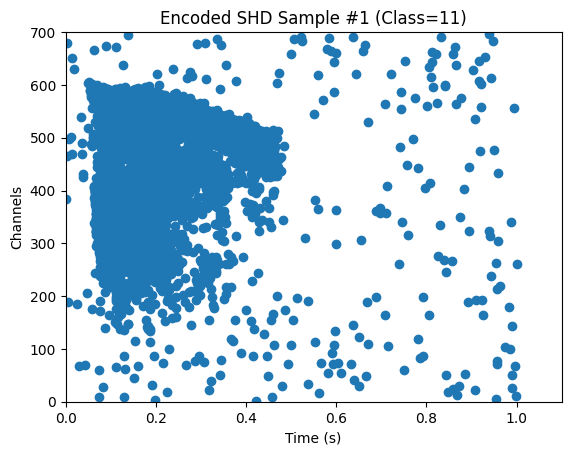

In [1]:
# - Imports for loading data
import tonic
from tonic import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import torch

from rockpool.timeseries import TSEvent

import matplotlib.pyplot as plt

download_dir='./data'

# - Download and import the training data. The transform ensures the data has a floating type
train_data = datasets.SHD(download_dir, train=True, transform=transforms.NumpyAsType(float))

train_dl = DataLoader(train_data, drop_last=True, shuffle=False)

# - Visualise Data
events, label = next(iter(train_dl))

# Extract values for the first sample from the dataloader
times=events[0,:,0]
events=events[0,:,1]

# Create a TSEvent object corresponding to the first sample
spikes_ts = TSEvent(
    times=times/times.max(), # Divide by the maximum timestep for a clearer plot
    channels=events.numpy(),
    t_stop=times.max()+1
)
spikes_ts.plot()
plt.title(f'Encoded SHD Sample #1 (Class={label.item()})')
plt.xlim((0, 1.1))
plt.ylim((0, 700))
plt.show()

As we can see, a given sample consists of some number of events across 700 channels and some duration of time. 700 channels means a high-dimensional dataset, and so large training times and networks. For low-power applications, it is desirable to use lower dimensional input. Using Tonic, we can transform the input into a better format. We can rasterise the input to facilitate training. Note: the duration of each sample may be different, thus it is useful to pad samples to make them of uniform length. We define the following parameters. Initially, we will use an encoding dimension of 20, i.e., reduce 700 input channels to 20.

In [2]:
batch_size=256
encoding_dim=20
dt=4000
num_workers=6

We now create a class to rasterise the input:

In [3]:
class ToRaster():
    def __init__(self, encoding_dim):
        self.encoding_dim = encoding_dim

    def __call__(self, events):
        # tensor has dimensions (time_steps, encoding_dim)
        tensor = np.zeros((events["t"].max()+1, self.encoding_dim), dtype=int)
        np.add.at(tensor, (events["t"], events["x"]), 1)
        return tensor[:250,:]

Now we can define the transforms which we apply to the dataset to prepare it for training:

In [4]:
transform = transforms.Compose([
            transforms.Downsample(time_factor=1/dt, spatial_factor=encoding_dim/700),
            ToRaster(encoding_dim)
        ])

Reload the dataset with the applied transforms:

In [5]:
train_data = datasets.SHD(download_dir, train=True, transform=transform)

train_dl = DataLoader(train_data, num_workers=num_workers, batch_size=batch_size, 
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False)

`tonic.collation.PadTensors(batch_first=True)` performs padding to ensure a consistent sample length for each sample across all batches. `ToRaster` above indicates a maximum sample length of 250 points.

We can now visualise the first sample in its encoded form in the same way as before:

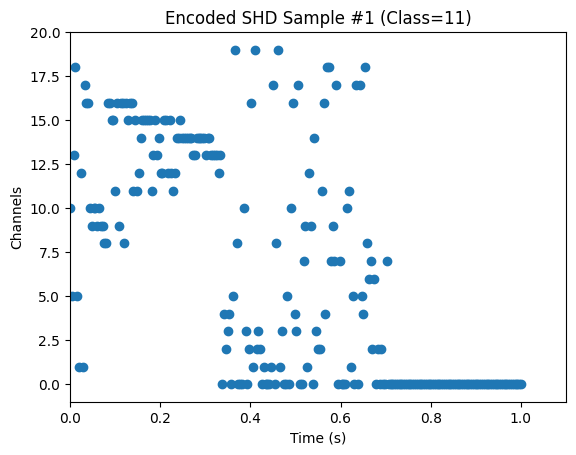

In [6]:
events, label = next(iter(train_dl))
times=np.linspace(0, 1, 250)
encoded = torch.argmax(events[0,:,:], dim=1)
spikes_ts = TSEvent(
    times=np.linspace(0, 1, 250),
    channels=encoded.numpy(),
    t_stop=1.1
)
spikes_ts.plot()
plt.title(f'Encoded SHD Sample #1 (Class={label[0].item()})')
plt.show()

Now that our data is in the correct format, we can define our network. To begin, we use a simple network consisting of a linear layer, a leaky integrate-and-fire layer, another linear layer, and an exponential synapse output layer:

In [7]:
from rockpool.nn.modules import LIFTorch, LinearTorch, ExpSynTorch
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# Use a GPU if available for faster training
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 

# - Network Definition
def SimpleNet(Nin, Nhidden, Nout):
    return Sequential(
        LinearTorch((Nin, Nhidden), has_bias=False),
        LIFTorch(Nhidden,
            tau_mem=Constant(0.1),
            tau_syn=Constant(0.1),
            threshold=Constant(1.),
            bias=Constant(0.),
            learning_window=Constant(0.5),
            dt=Constant(0.1),
            has_rec=False),
        LinearTorch((Nhidden, Nout), has_bias = False),
        ExpSynTorch(Nout, dt=Constant(0.02), tau=Constant(0.01), noise_std=Constant(0))
    )

Note, we use the `Constant` functionality here as, by default, all parameters in Rockpool are trainable. Keeping everything except the weights constant ensures fast training for the example. We can now define our network shape:

In [8]:
# - Build a network
Nin = encoding_dim
Nhidden = 20
Nout = 20

torch.manual_seed(1234) # A manual seed ensure repeatability

net = SimpleNet(Nin, Nhidden, Nout).to(dev)

We can test the network output makes sense here. Setting `record=True` as an argument in the network allows you to save the record dictionary of the network at each layer. Let's pass the first sample to the network and see what happens:

In [9]:
events, labels = next(iter(train_dl)) # Get the first batch from the train dataloader
events, labels = events.to(device), labels.to(device) # Send the data to our training device

sample = events[0,:,:] # Get the first sample from the first batch

output, state, rec = net(sample, record=True) # Pass the first sample through the network

Here, we see the network returns three things: the network output, the current network state, and the record dictionary. The output is a 3D Tensor of shape: `[batch_size*[times*[channels]]]`. It may help to visualise this as a Tensor of size `batch_size` (256 here) which contains another tensor whose size is equal to the number of time steps (250 in this case). This tensor contains 250 1x20 tensors, with each element corresponding to the number of neurons in the ExpSynTorch layer. You may have seen us index tensors already in this tutorial, e.g., in the `sample = events[0,:,:]` line above. Tensor indexing here works as follows: `tensor_name[batch_item, timestep, channel]`. For example, to access the fifth neuron at the second timestep in the eighth sample in the batch, one should type `sample = events[8,1,5]`. To select all channels, timesteps, or batch items, use `:`, e.g., to access all channels and timesteps in the first sample, type `sample = events[0,:,:]`. 

The network state gives us the output of each layer in the network for a given input. The record dictionary stores all states for a given batch. To improve training time and reduce memory overheads, you may wish to skip the `record=True` argument, however it can be invaluable for debugging if the network doesn't behave as expected. For example, if the network does not appear to give any output, one can use the record dictionary to determine whether a specific layer is at fault. 

Now that we understand what our network outputs, we can define our training process. As SHD is a classification task, we use [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) as our loss function. We use Adam as our optimiser.

In [10]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

# - Get the optimiser functions
optimizer = Adam(net.parameters().astorch(), lr=1e-3)
# - Loss function
loss_fun = CrossEntropyLoss()

We are now ready to build our training loop:

Loss: 5.51276: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]

Training Accuracy: 15.965%


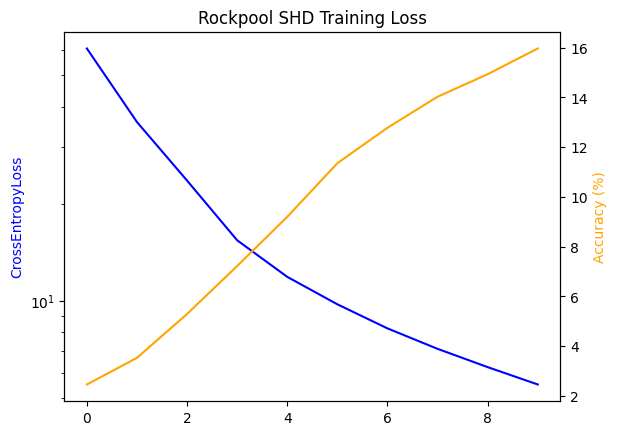

In [11]:
# Import tqdm to visualise training progress
from tqdm.autonotebook import tqdm

# - Record the loss values over training iterations
accuracy = []
loss_t = []
num_epochs = 10

# - Training Loop
pbar = tqdm(range(num_epochs))
for _ in pbar:    
    correct = 0
    total_loss = 0
    total = 0
    temp_loss = 0

    net.train()

    for events, labels in train_dl:
        events, labels = events.to(dev), labels.to(dev)
        optimizer.zero_grad()

        output, _, _ = net(torch.Tensor(events).float())

        sum = torch.cumsum(output, dim=1)

        loss = loss_fun(sum[:,-1,:], labels)
        
        loss.backward()
        optimizer.step()

        # Calculate the number of correct answers
        predicted = torch.argmax(sum[:,-1,:], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        temp_loss = loss.item()

    # - Keep track of the accuracy
    accuracy.append((correct/total)*100)
    loss_t.append(temp_loss)
    pbar.set_description(f"Loss: {temp_loss:.5f}")

print(f"Training Accuracy: {accuracy[-1]:.3f}%")

# - Plot the Training Loss
fig, ax = plt.subplots()
ax.plot(loss_t, color='blue')
ax.set_ylabel('CrossEntropyLoss', color='blue')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.plot(accuracy, color='orange')
ax2.set_ylabel('Accuracy (%)', color='orange')
ax2.set_yscale('linear')

plt.xlabel('Epochs')
plt.title('Rockpool SHD Training Loss')
plt.show()

As the plot shows, our network successfully trains on the data! Feel free to experiment with different values for the learning rate, number of epochs and network parameters to see how the different parameters affect the network performance. The best values for the parameters will depend on the dataset. For example, here if `tau_mem` or `tau_syn` are too small (below about 0.02 for `threshold = 1.`), then the LIF layer will not fire and the network will not train. Depending on your application, it may be necessary to trial different values. As we note above, looking at the record dictionary can be very useful in figuring out what's happening under the hood.

It's worthwhile here to discuss the nature of the training loop. For a given sample or batch of samples that the network takes as input the network output is as described above, i.e., a tensor with the ExpSyn layer outputs for each batch and at each timestep. We want to integrate the output for each neuron over time, i.e., the synaptic current, `isyn` and pass this to the CrossEntropyLoss function. We do perform this integration by taking the cumulative sum of the synaptic currents for each channel using `sum = torch.cumsum(output, dim=1)`. The loss function expects a Tensor of size [batch_size*[channels]] and so we need to take the value for the last timestep, which we do by indexing `sum[:,-1,:]`. As we note above, the SHD dataset has 20 possible output classes. Our network's 20 output neurons correspond to a class, and so our prediction is the specific neuron with the largest synaptic current. We can easily find this by taking the argmax of the output neurons at the last timestep. This allows us to calculate the accuracy as above.

Let's see how the network fares on data it hasn't seen before. First we load the test data and transform it in the same way as for the training data:

In [12]:
test_data = datasets.SHD(download_dir, train=False, transform=transform)

test_dl = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size, 
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False)

We can now build our test loop to see how the network performs on the validation set:

In [13]:
# - Test loop:
net.eval()
accuracy = 0
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0

    for events, labels in test_dl:
        events, labels = events.to(dev), labels.to(dev)
        output, _, _ = net(torch.Tensor(events).float())

        sum = torch.cumsum(output, dim=1)
        
        predicted = torch.argmax(sum[:,-1,:], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = (correct/total)*100

print(f"Test Accuracy: {accuracy:.3f}%")

Test Accuracy: 16.113%


As we see, the network doesn't perform as well on the test data, but by playing around with the different parameters, as well as introducing techniques such as Dropout or regularisation, one should be able to obtain good performance. The authors provide a [leaderboard](https://zenkelab.org/resources/spiking-heidelberg-datasets-shd/) for the best-performing networks, which, at the time of writing, has 48.1% in 6th place, and 91.1% in first place.